imported
i was here
i was here
initialized
5342/5344 [============================>.] - ETA: 0s - loss: 1.1278
Epoch 00001: saving model to D:\studies\university\thesis\speech_separation_codes\du16\donesomestuff\checkpoints\normal\cp-0001.ckpt
5344/5344 [==============================] - 217s 41ms/step - loss: 1.1277 - val_loss: 1.8208
Saved model to disk


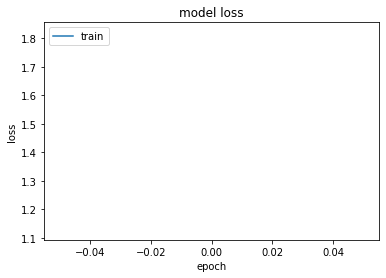

In [3]:
#import libraries.
import numpy as np
# from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
#import sounddevice as sd
# import tensorflow as tf
# tf.enable_eager_execution()
from pystoi.stoi import stoi
import h5py
######################
#import libraries.
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
####import sounddevice as sd
import time
print('imported')
# #######################
Data_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff'
input_tr_name = 'lilftr_refrmd'
input_val_name = 'ftr_refrmd_test'
target_tr_name = 'lilsingle_dataset_log_16'
target_val_name = 'clean_data'
tfrecord_folder_parent = 'tfrecord_files'
tfrecord_folder = 'tfrecord_files_3h'
tfrecord_val_folder = 'test'
input_tr_path = os.path.normpath(os.path.join(Data_path,input_tr_name))
input_val_path = os.path.normpath(os.path.join(Data_path,input_val_name))
target_tr_path = os.path.normpath(os.path.join(Data_path,target_tr_name))
target_val_path = os.path.normpath(os.path.join(Data_path,target_val_name))

file = h5py.File(target_val_path+'.hdf5','r')
val_y = file[target_val_name][0:]
file.close()
file = h5py.File(input_val_path+'.hdf5','r')
val_x = file[input_val_name][0:]
file.close()

hh = h5py.File(target_tr_path+'.hdf5', 'r')
d=hh[target_tr_name]
len_data=d.shape
hh.close()

file = h5py.File(target_val_path+'.hdf5','r')
val_y = file[target_val_name]
val_len=val_y.shape
file.close()

w=3
# print(len_data)
#######################
#define reconstruct function to reconstruct sound from framed signal.
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=200, win_length=500, window='hann')
    return recon
#######################
I=0
global batch_size
batch_size=128
# epochs_num=50
global datalen
datalen=len_data[0]

file.close()
h = [1024,512]
seed = 7
from tensorflow.keras.layers import Activation
np.random.seed(seed)
model = Sequential()
act=layers.LeakyReLU(alpha=0.1)
model.add(Dense(h[0], input_dim = w*len_data[1]))
# model.add(BatchNormalization())
model.add(act)
act=layers.LeakyReLU(alpha=0.1)
model.add(Dense(h[1]))
model.add(act)
act=layers.LeakyReLU(alpha=0.1)
model.add(Dense(len_data[1]))
#############################################
import os
from natsort import natsorted

def _parse_function(example_proto):
    features = {"X": tf.FixedLenFeature((3*257), tf.float32),
              "Y": tf.FixedLenFeature((257), tf.float32)}
    parsed_features = tf.parse_single_example(example_proto, features)
    print("i was here")
    return parsed_features["X"], parsed_features["Y"]

# orig_path = os.getcwd()
tfrecord_path = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
sorted_names = natsorted(os.listdir(tfrecord_path))
trainfilenames = []
for i in sorted_names:
    trainfilenames.append(os.path.normpath(os.path.join(tfrecord_path,i)))
filenames = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(_parse_function)  # Parse the record into tensors.
dataset = dataset.repeat()  # Repeat the input indefinitely.
dataset = dataset.batch(128)
iterator = dataset.make_initializable_iterator()


tfrecord_path_val = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_val_folder))
sorted_names_val = natsorted(os.listdir(tfrecord_path_val))
trainfilenames_val = []
for i in sorted_names_val:
    trainfilenames_val.append(os.path.normpath(os.path.join(tfrecord_path_val,i)))
filenames_val = tf.placeholder(tf.string, shape=[None])
dataset_val = tf.data.TFRecordDataset(filenames_val)
dataset_val = dataset_val.map(_parse_function)  # Parse the record into tensors.
dataset_val = dataset_val.repeat()  # Repeat the input indefinitely.
dataset_val = dataset_val.batch(128)
iterator_val = dataset_val.make_initializable_iterator()


# You can feed the initializer with the appropriate filenames for the current
# phase of execution, e.g. training vs. validation.
# next_elem = iterator_val.get_next()
# Initialize `iterator` with training data.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(iterator.initializer, feed_dict={filenames: trainfilenames})
    sess.run(iterator_val.initializer, feed_dict={filenames_val: trainfilenames_val})
    print("initialized")
    model.compile(loss='mean_squared_error', optimizer='adam')
    epochs_num=1
    steps = len_data[0] // batch_size
    val_steps = val_len[0] // batch_size
    checkpoint_path = os.path.normpath(os.path.join(Data_path, "checkpoints/normal/cp-{epoch:04d}.ckpt"))
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=1, save_weights_only=False,
        # Save weights, every 5-epochs.
        period=1)
    history = model.fit( iterator, steps_per_epoch=steps,epochs=epochs_num, callbacks = [cp_callback], verbose=1,validation_data=iterator_val,validation_steps=val_steps)
    model.save(os.path.normpath(os.path.join(Data_path, "model_3h_dataset.json")))
#     model_json = model.to_json()
#     with open(os.path.normpath(os.path.join(Data_path, "model_3h_dataset.json", "w"))) as json_file:
#         json_file.write(model_json)
#     model.save_weights(os.path.normpath(os.path.join(Data_path, "model_3h_dataset.json", "w")))
    print("Saved model to disk")
# %matplotlib inline
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# model_json = model.to_json()
# with open("model_10h_dataset.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model_10h_dataset.h5")
# print("Saved model to disk")

In [2]:
tf.__version__

'1.13.1'

In [51]:
tf.__version__

'1.13.1'

In [27]:
a=tf.constant([1,2,3])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    label_numpy = a.eval()

In [97]:
import h5py 
import tensorflow as tf
hh = h5py.File('ftr_refrmd_10h.hdf5', 'r')
d=hh['ftr_refrmd_10h'][0]
len_data=d.shape
hh.close()
len_data

(771,)

In [24]:
file.close()

In [92]:
dataset

<PrefetchDataset shapes: ((?, 257), (?,)), types: (tf.float32, tf.float32)>